In [1]:
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np

In [2]:
!ls

checking.ipynb		  hadd1.root	    hadd.root
cPMinBiasCorrectPaths.sh  hadd2.root	    hadd.sh
cPMinBias.txt		  hadd3.root	    MinBiasCorrectPaths.sh
file.root		  hadd4.root	    nohup.out
Fix_paths.ipynb		  hadded	    rateAnalysis.ipynb
hadd0.root		  hadd_of_hadds.sh


In [3]:
!pwd

/uscms_data/d3/rmarroqu/el8cmsL1trigger_Analysis/work/CMSSW_14_0_0_pre3/src/MinBias


In [4]:
!pwd

/uscms_data/d3/rmarroqu/cmsL1trigger_Analysis/work/CMSSW_14_0_0_pre3/src/MinBias


In [4]:
f = uproot.open("/uscms_data/d3/rmarroqu/el8cmsL1trigger_Analysis/work/CMSSW_14_0_0_pre3/src/MinBias/hadded/complete_hadd.root")

lxplus files...

In [5]:
#f = uproot.open("root://cmsxrootd.fnal.gov///store/group/dpg_trigger/comm_trigger/L1Trigger/alobanov/phase2/menu/ntuples/14X/v38/MinBias_TuneCP5_14TeV-pythia8/MinBias_131_L1Fix_IBv9_wTT/240412_211203/0000/test_100.root")

In [6]:
llpScores = f["Events"]["L1puppiExtJetSC4_llpTagScore"].arrays()

In [7]:
len(llpScores)

3259988

Apply the llpScore cut jets in each event... the code below returns True or False for each jet.

In [8]:
accepted_Evs09 = ak.sum(llpScores['L1puppiExtJetSC4_llpTagScore'] > 0.9, axis =-1) > 1 # At least 1 jet passes
#     the probability threshold; gives boolean
accepted_Evs08 = ak.sum(llpScores['L1puppiExtJetSC4_llpTagScore'] > 0.8, axis =-1) > 1 # At least 1 jet passes
#     the probability threshold; gives boolean

In [9]:
pT = f["Events"]["L1puppiExtJetSC4_pt"].arrays()

In [14]:
eta = f["Events"]["L1puppiExtJetSC4_eta"].arrays()

63

In [10]:
ZeroBiasRate = 11.2456*2544 #kHZ

## Ordering by LLP Score

Below, I sort the LLP scores starting with the highest score of accepted events from above cut. The array below stores the index position

In [11]:
idxHighLLPscore_accepted08 = ak.argsort(llpScores[accepted_Evs08]['L1puppiExtJetSC4_llpTagScore'], ascending=False)[0:,0]

In [12]:
np.argmax(llpScores[accepted_Evs08]['L1puppiExtJetSC4_llpTagScore'][2]) #check indicies manually from list below

2

In [13]:
idxHighLLPscore_accepted08

<Array [1, 1, 2, 4, 3, 2, 4, ..., 5, 3, 0, 0, 5, 5, 1] type='3257081 * int64'>

In [14]:
pT_accepted_Evs09 = pT['L1puppiExtJetSC4_pt'][accepted_Evs09]
pT_accepted_Evs08 = pT['L1puppiExtJetSC4_pt'][accepted_Evs08]

Below, I select on each dimension by an index and flatten this. The total count is number of event that passed the score cut.

In [15]:
orderByScorePt08 = ak.flatten(pT_accepted_Evs08[np.arange(len(pT_accepted_Evs08))[:,None], idxHighLLPscore_accepted08[0:,None]])

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


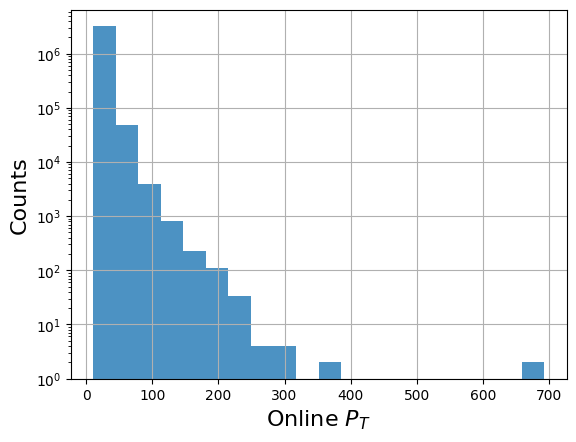

In [16]:
(countsPt08, binsPt08, _) = plt.hist(orderByScorePt08,bins=20, alpha= 0.8,)
plt.yscale("log")
plt.xlabel("Online $P_T$", fontsize=16)
plt.ylabel("Counts", fontsize=16)
plt.grid(True)

In [17]:
bin_centersPt08 = []
for i in range (len(binsPt08)-1):
    bcPt08 = (binsPt08[i+1] + binsPt08[i])/2
    bin_centersPt08.append(bcPt08)


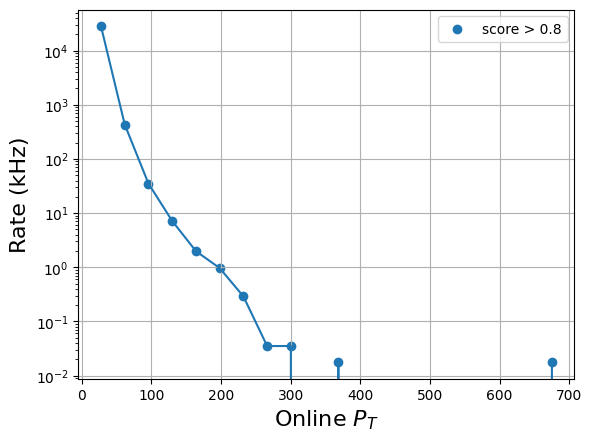

In [34]:
plt.scatter(bin_centersPt08, (countsPt08*ZeroBiasRate)/len(orderByScorePt08), label="score > 0.8")
plt.plot(bin_centersPt08, (countsPt08*ZeroBiasRate)/len(orderByScorePt08))
plt.yscale("log")
plt.xlabel("Online $P_T$", fontsize=16)
plt.ylabel("Rate (kHz)", fontsize=16)
plt.legend()
plt.grid(True)

In [19]:
len(pT), len(pT_accepted_Evs09), len(pT_accepted_Evs08),

(3259988, 3250314, 3257081)

## Sorting by $P_T$

The LLP cut above is applied to each jet, returning True or False if they pass or not. What I need here is: all the jets that pass (True), sort them by $P_T$, and plot the rates using highest $P_T$. So, I can use the events and jets selected above, remove all the False's, sort by $P_T$, and take the jet with highest $P_T$.

First, I apply $\eta$ cuts to P_T and llpTagScores arrays...

In [19]:
eta_mask = (eta['L1puppiExtJetSC4_eta'] > -2.4) & (eta['L1puppiExtJetSC4_eta'] < 2.4) #eta jet selections per event

In [20]:
eta_mask

<Array [[True, True, True, ..., True, True], ...] type='3259988 * var * bool'>

In [ ]:
ak.sum((eta_mask >= 1), axis=1) # counts the number of True's across events because TRUE == 1

In [57]:
eta_cut = ak.sum((eta_mask >= 1), axis=1) > 0 #If # of True's is above 0, then select it (assign True), i.e. there is at least one jet 
#    within the eta range

Now, I apply the eta selection to both llpTagScore and $P_T$ arrays...

In [59]:
LLPscores = llpScores['L1puppiExtJetSC4_llpTagScore'][eta_cut]
Pt = pT['L1puppiExtJetSC4_pt'][eta_cut]

In [110]:
len(pT) - len(Pt) # number of events that do not pass eta cut

63

Next is the LLP Score selection applied on the $P_T$ array.

In [62]:
ak.sum((LLPscores > 0.8), axis=1); # Counts the # of jets across events with LLP score > 0.8
ak.sum((LLPscores > 0.95), axis=1); # Counts the # of jets across events with LLP score > 0.95

In [69]:
llpScore_cut80 = ak.sum((LLPscores > 0.8), axis=1) > 0 #If # of jets (> 0.8) is above 0, then selects it (assigns True)
llpScore_cut95 = ak.sum((LLPscores > 0.95), axis=1) > 0 #If # of jets (> 0.95) is above 0, then selects it (assigns True)

In [72]:
pT_score80 = Pt[llpScore_cut80]
pT_score95 = Pt[llpScore_cut95]

In [116]:
print("{} events do not pass 0.8 cut and {} events do not pass 0.95 cut out of {} events ".\
    format(len(pT) - len(pT_score80), len(pT) - len(pT_score95), len(pT)))

393 events do not pass 0.8 cut and 19619 events do not pass 0.95 cut out of 3259988 events 


In [ ]:
ak.num(pT_score95, axis=1) # counts entries with empty events

Jets are already pT sorted, so I am getting the first position in each event...

In [89]:
leadJetPt_score80 = pT_score80[:, 0]
leadJetPt_score95 = pT_score95[:, 0]

In [96]:
len(leadJetPt_score95)

3240369

Histograms:

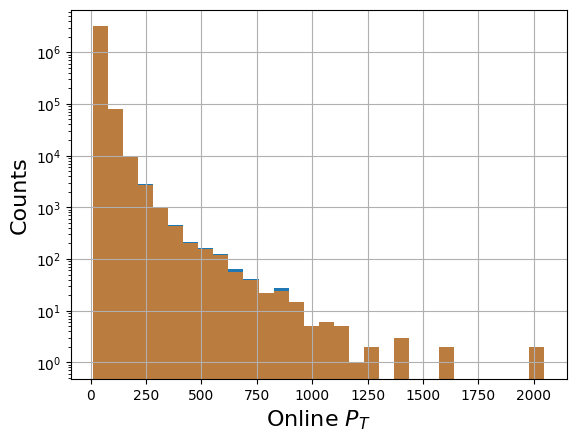

In [95]:
(pTcounts_score80, pTbins_score80, _) = plt.hist(leadJetPt_score80, bins=30)
(pTcounts_score95, pTbins_score95, _) = plt.hist(leadJetPt_score95, bins=30, alpha = 0.7)
plt.yscale("log")
plt.ylabel("Counts", fontsize=16)
plt.xlabel("Online $P_T$", fontsize=16)
plt.grid(True)

In [99]:
bin_centers80 = []
bin_centers95 = []
for i in range (len(pTbins_score80)-1):
    bc08 = (pTbins_score80[i+1] + pTbins_score80[i])/2
    bin_centers80.append(bc08)
    bc09 = (pTbins_score95[i+1] + pTbins_score95[i])/2
    bin_centers95.append(bc09)

In [121]:
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2

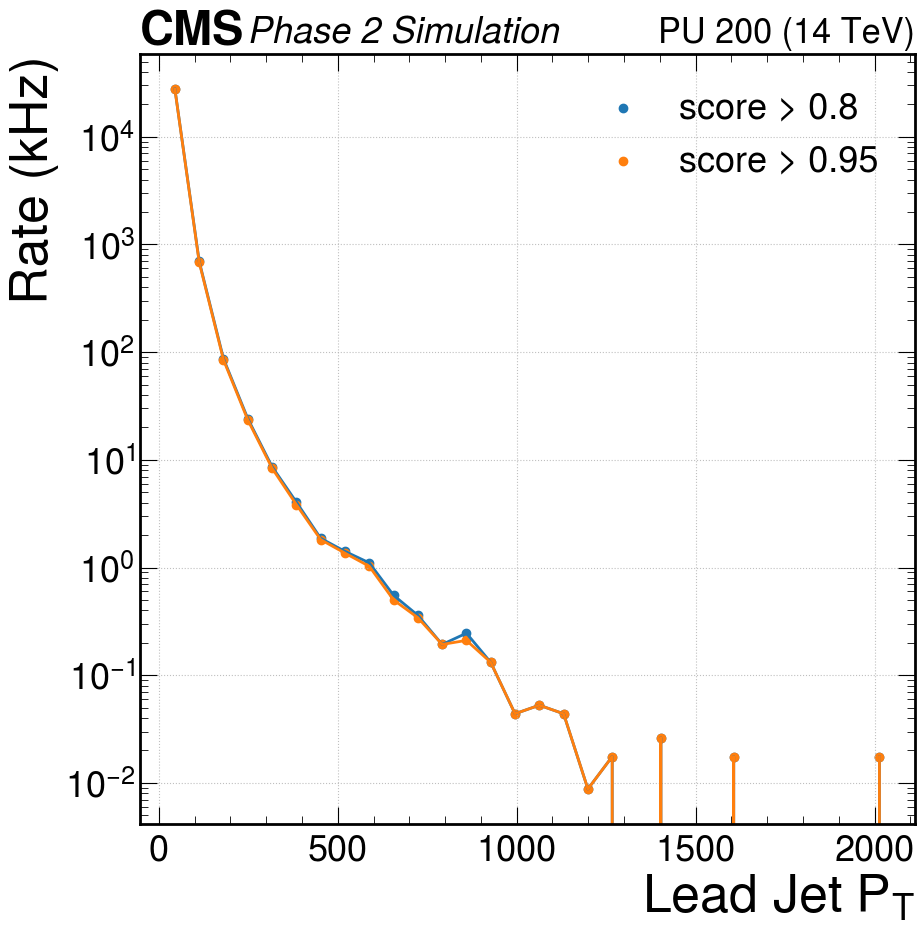

In [126]:
plt.scatter(bin_centers80, (pTcounts_score80/len(pT))*ZeroBiasRate, label = "score > 0.8")
plt.plot(bin_centers80, (pTcounts_score80/len(pT))*ZeroBiasRate)

plt.scatter(bin_centers95, (pTcounts_score95/len(pT))*ZeroBiasRate, label = "score > 0.95")
plt.plot(bin_centers95, (pTcounts_score95/len(pT))*ZeroBiasRate)

hep.cms.text("Phase 2 Simulation")
hep.cms.lumitext("PU 200 (14 TeV)")

plt.yscale("log")
plt.ylabel("Rate (kHz)" )
plt.xlabel("Lead Jet $P_T$")
plt.legend()
plt.grid(True)
plt.savefig("NNrate_MinBias.pdf", format='pdf',  bbox_inches='tight')


In [ ]:
!pwd

/uscms_data/d3/rmarroqu/cmsL1trigger_Analysis/work/CMSSW_14_0_0_pre3/src/MinBias


HLS_qk_Roc.py				profiling_q_activation_2.png
README.md				profiling_q_conv1d.png
ROCCurveQK.png				profiling_q_conv1d_1.png
dist.png				profiling_q_dense.png
hls4ml_prj				profiling_q_dense_1.png
hls_Qk_ROCCurve.png			profiling_sigmoid.png
model_summary.png			qkL1JetTagModel.h5
output_correlation.png			qkL1JetTagModel_hls_config.ipynb
profiling_global_average_pooling1d.png	qkModLoss.png
profiling_q_activation.png		qkROC.py
profiling_q_activation_1.png		qkerasModel.py


In [ ]:
events

<Array [{run: 1, ...}, ..., {run: 1, ...}] type='299 * {run: uint32, lumino...'>

In [ ]:
events["run"]

<Array [] type='0 * uint32'>

In [ ]:
events["L1puppiExtJetSC4_btagScore"]

<Array [[0.504, 0.637, 0.304, ..., -1, -1, -1], ...] type='299 * var * float32'>

In [ ]:
l = []

In [ ]:
i=0

In [ ]:
for nev in events:
    if i == 10: break
    print(i)
    #print(events["event"])
    l.append(events["L1puppiExtJetSC4_llpTagScore"])
    i+=1

0
1


Shouldn't I be getting the same event #'s? at every iteration?

In [ ]:
l[0][0]

<Array [0.144, 0.981, 0.977, 0.959, ..., -1, -1, -1, -1] type='16 * float32'>